# Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from scipy.stats.contingency import association
from scipy.stats import f_oneway,ttest_ind,ttest_1samp

# Extração da base

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/JackyP/testing/master/datasets/nycflights.csv", index_col=0)


In [3]:
df.shape

(336776, 16)

# Qualidade dos Dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336776 entries, 1 to 336776
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       336776 non-null  int64  
 1   month      336776 non-null  int64  
 2   day        336776 non-null  int64  
 3   dep_time   328521 non-null  float64
 4   dep_delay  328521 non-null  float64
 5   arr_time   328063 non-null  float64
 6   arr_delay  327346 non-null  float64
 7   carrier    336776 non-null  object 
 8   tailnum    334264 non-null  object 
 9   flight     336776 non-null  int64  
 10  origin     336776 non-null  object 
 11  dest       336776 non-null  object 
 12  air_time   327346 non-null  float64
 13  distance   336776 non-null  int64  
 14  hour       328521 non-null  float64
 15  minute     328521 non-null  float64
dtypes: float64(7), int64(5), object(4)
memory usage: 43.7+ MB


In [5]:
df.isna().sum()

year            0
month           0
day             0
dep_time     8255
dep_delay    8255
arr_time     8713
arr_delay    9430
carrier         0
tailnum      2512
flight          0
origin          0
dest            0
air_time     9430
distance        0
hour         8255
minute       8255
dtype: int64

Uma vez que os atrasos são nossa resposta, vamos retirar os casos em que eles são na

In [6]:
df.dropna(subset=['arr_delay','dep_delay'],inplace=True)

In [7]:
df.shape

(327346, 16)

In [8]:
df.isna().sum().sum()

0

In [9]:
df.duplicated().sum()

0

Está OK

# Analise dos dados

Primeiros vamos criar um date-time para futuras análises e tratar a variável flight

In [10]:
df["data"] = pd.to_datetime(df[['year', 'month', 'day']]) 
df.flight = df.flight.astype('str')

## 1.Variavel Resposta

Queremos medir atraso, como vamos criar essa medida?

Temos atraso na partida e na chegada. Podemos utilizar a soma dos dois como uma métrica de atraso total

In [11]:
df['atraso_total'] = df.dep_delay + df.arr_delay

In [12]:
df.atraso_total.describe()

count    327346.000000
mean         19.450532
std          82.880678
min        -100.000000
25%         -21.000000
50%          -6.000000
75%          22.000000
max        2573.000000
Name: atraso_total, dtype: float64

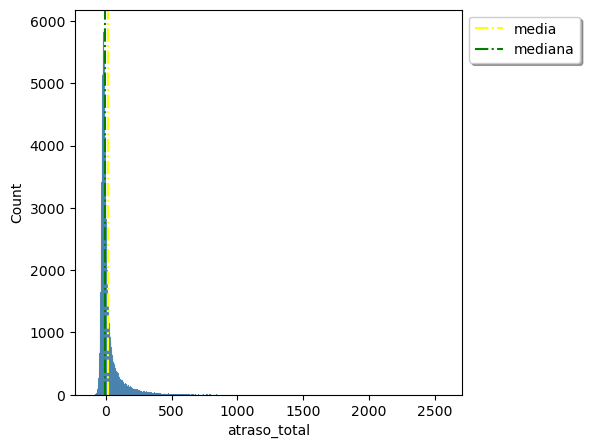

In [13]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df,
             x='atraso_total',
             discrete=True)
plt.axvline(df.atraso_total.mean(),color='yellow',ls='-.',label='media')
plt.axvline(df.atraso_total.median(),color='green',ls='-.',label='mediana')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left',fancybox=True,shadow=True)
plt.show()

Uma vez que não temos uma distribuição normal, vamos utilizar o Chebyshev

In [14]:
def analisa_outliers(base,parametro,k):
    intervalo = (1-(1/k**2))*100
    valores_min = base[parametro].mean() - k*base[parametro].std() 
    valores_max = base[parametro].mean() + k*base[parametro].std() 
    print(f'Para um intervalo de confiança de {(round(intervalo,2))}% teremos entre \n {round(valores_min,2)} e {round(valores_max,2)}')

In [15]:
analisa_outliers(base=df,
                 parametro='atraso_total',
                 k=3)

Para um intervalo de confiança de 88.89% teremos entre 
 -229.19 e 268.09


## 2. Analises Iniciais

### Por data

Vamos entender os outliers presentes na base, pois atrasos de mais de 268 minutos (4 horas) são críticos

<Axes: xlabel='month', ylabel='count'>

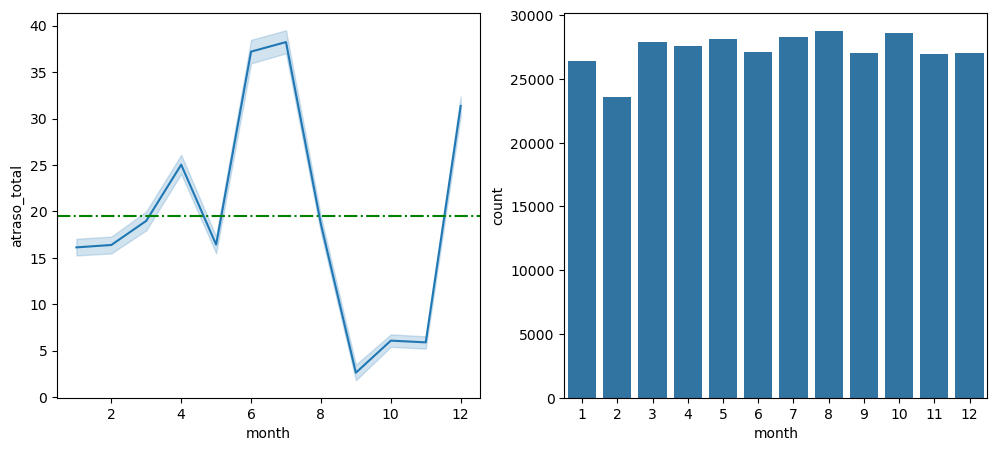

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(data=df,
             x='month',
             y='atraso_total',
             ax=ax[0])
ax[0].axhline(df.atraso_total.mean(),color='green',ls='-.',label='media')
sns.countplot(data=df,
             x='month',
             ax=ax[1])



Podemos perceber que os meses de férias são críticos (6,7 e 12)\
Enquanto que a baixa temporada (meses 9,10,11) estão bem abaixo da média.\
O gráfico da direita demonstra que a quantidade de voos não está afetando o resultado do mês

In [17]:
df.loc[df.atraso_total > 268,'OUTLIER'] = 'SIM'
df.loc[df.OUTLIER.isna(),'OUTLIER'] = 'NAO'

In [18]:
base_apoio = pd.crosstab(index=df.month,
                         columns=df.OUTLIER,
                         normalize='index')

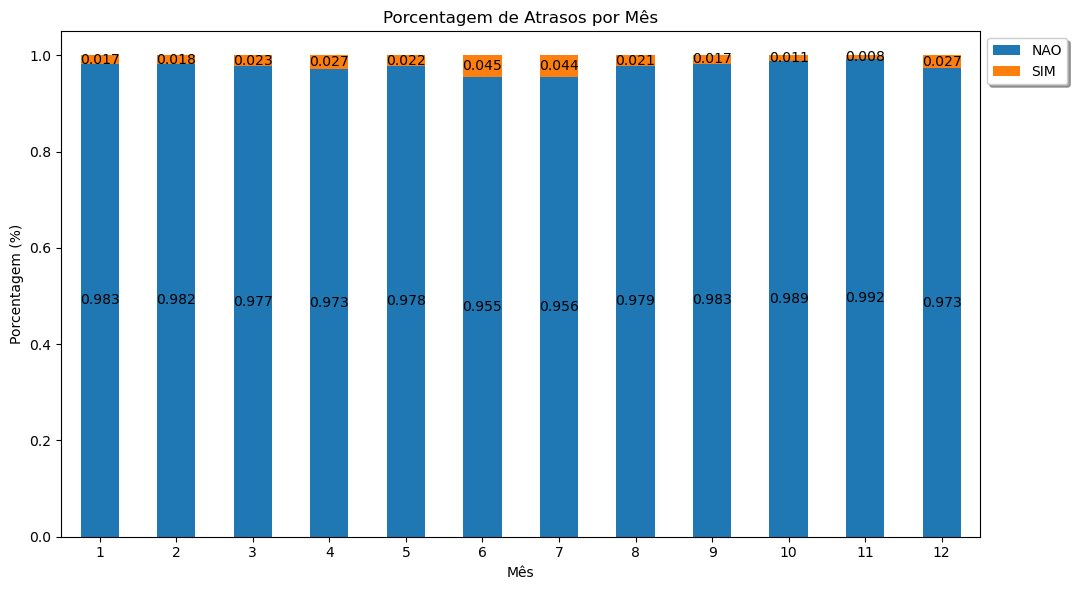

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
barras = base_apoio.plot(kind='bar',
                stacked=True,
                ax=ax)
for bar in barras.containers:
    ax.bar_label(bar, fmt='%.3f', label_type='center')
ax.set_xlabel('Mês')
ax.set_ylabel('Porcentagem (%)')
ax.set_title('Porcentagem de Atrasos por Mês')
plt.xticks(rotation=360)
plt.tight_layout()
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left',fancybox=True,shadow=True)
plt.show()

In [20]:

# plt.figure(figsize=(8,5))
# sns.countplot(data=df,
#               x='month',
#               hue='OUTLIER',
#               dodge=False)
# plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left',fancybox=True,shadow=True)
# plt.title('Relacao entre data do voo e atraso "extremo"')
# plt.show()

Aqui podemos perceber que o mesmo comportamento geral é replicado para os casos extremos, indicando que existe implicação entre o aumento do atraso nos meses de férias

### Por CIA Aerea

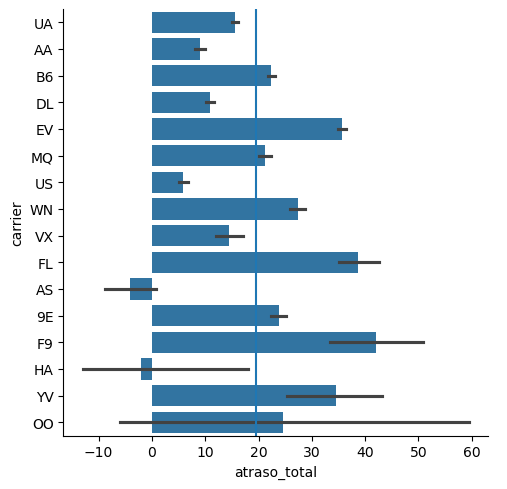

In [21]:
sns.catplot(data=df,
            x='atraso_total',
            y='carrier',
            kind='bar')
plt.axvline(df.atraso_total.mean())

In [22]:
df.OUTLIER.value_counts(normalize=True)

OUTLIER
NAO    0.97649
SIM    0.02351
Name: proportion, dtype: float64

In [23]:
base_apoio = df.groupby('carrier').OUTLIER.value_counts(normalize=True).reset_index()
base_apoio[(base_apoio.OUTLIER == 'SIM')&
           (base_apoio.proportion > 0.02)][['carrier','proportion']].sort_values('proportion',
                                                                                 ascending=False)

,carrier,proportion
21,OO,0.068966
13,F9,0.045521
31,YV,0.044118
15,FL,0.039055
11,EV,0.037372
1,9E,0.035041
29,WN,0.031302
27,VX,0.028342
7,B6,0.023442


In [24]:
df[df.carrier.isin(['OO','F9','EV','YV','FL'])].groupby('carrier').atraso_total.agg(['mean','median','std', 'min','max','count'])

,mean,median,std,min,max,count
carrier,,,,,,
EV,35.635360,-1.0,95.168201,-80.0,1113.0,51108
F9,42.121880,8.0,117.970179,-50.0,1687.0,681
FL,38.721890,6.0,105.406728,-66.0,1174.0,3175
OO,24.517241,-13.0,90.777051,-37.0,294.0,29
YV,34.455882,-4.0,100.725992,-59.0,768.0,544


In [25]:
df.atraso_total.describe()

count    327346.000000
mean         19.450532
std          82.880678
min        -100.000000
25%         -21.000000
50%          -6.000000
75%          22.000000
max        2573.000000
Name: atraso_total, dtype: float64

Podemos observar aqui que temos algumas companhias que estão propensas a ter maior incidência desses casos, mais precisamente:
- OO &rarr; Tanto atrasa muito quanto tem ótimos indices de atraso (uma vez que tem a menor mediana)
- F9 &rarr; Mais crítica
- YV &rarr; Ainda tem muitos casos sem atraso
- FL &rarr; Segunda mais crítica
- EV &rarr; Idem YV

O contrário também ocorre para as seguintes cias:

- AS
- HA

In [26]:
df[df.carrier.isin(['AS','HA'])].groupby('carrier').atraso_total.agg(['mean','median','std', 'min','max','count'])

,mean,median,std,min,max,count
carrier,,,,,,
AS,-4.100141,-20.0,65.105997,-82.0,418.0,709
HA,-2.014620,-17.0,147.428783,-73.0,2573.0,342


### Origem do Voo

In [27]:
df.groupby('origin').atraso_total.agg(['mean','median','std'])

,mean,median,std
origin,,,
EWR,24.116165,-4.0,85.135466
JFK,17.575088,-7.0,81.050496
LGA,16.070071,-8.0,81.937556


In [28]:
amostra1 = df[df.origin == 'EWR'].atraso_total
amostra2 = df[df.origin == 'JFK'].atraso_total
amostra3 = df[df.origin == 'LGA'].atraso_total

In [29]:
anova = f_oneway(amostra1,amostra2,amostra3)

In [30]:
print(f'Temos que o resultado é {anova.statistic} e o p-value é {anova.pvalue}')



Temos que o resultado é 298.17862843554667 e o p-value é 4.173340745753458e-130


Sendo assim, a origem influencia no resultado sendo que o aeroporto EWD tende a ter mais atrasos

- Será que podemos conectar as companhias e os aeroportos?

<Axes: xlabel='origin', ylabel='Count'>

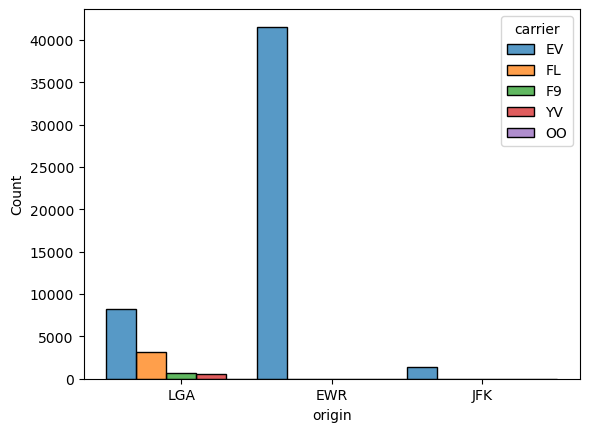

In [31]:
sns.histplot(data=df[df.carrier.isin(['OO','F9','EV','YV','FL'])],
             x='origin',
             hue='carrier',
             multiple='dodge')


Sendo assim, o resultado acima da média observado no aeroporto EWR é causado pelo alto volume de voos da CIA EV, que é indicada como uma das mais críticas

-> Sendo assim, mesmo o teste ANOVA apontando para diferenças entre as distribuições, a origem por si só não explica o atraso

-> Será que o resultado é afetado pelos meses em que esta CIA voa?

<Axes: xlabel='month', ylabel='count'>

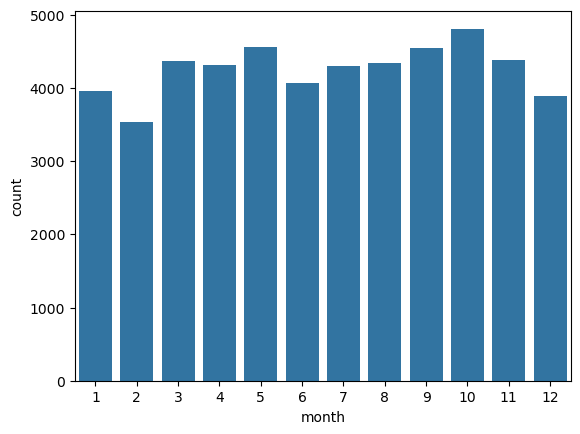

In [32]:
sns.countplot(data=df[df.carrier == 'EV'],
             x='month')

Não, é culpa da própria CIA


Sendo assim, podemos tirar desta análise inicial que iremos querer tratar nossa variavel resposta como atraso total (soma dos atrasos) e que devemos criar classificações para os meses, ao invés dos números em si, uma vez que o mesmo é muito sensível à outliers

In [33]:
df_2 = df

In [34]:
df_2.loc[df.month.isin([6,7,12]),'MES_FERIAS'] = 'FERIAS'
df_2.loc[df.month.isin([8,9,10,11]),'MES_FERIAS'] = 'BAIXA_TEMPORADA'
df_2.loc[df.month.isin([1,2,3,4,5]),'MES_FERIAS'] = 'PADRAO'
df_2.loc[df.MES_FERIAS.isna(),'MES_FERIAS'] = 'ERREI'

Agora vamos analisar o comportamento do atraso sem os casos em que o voo foi adiantado

In [35]:
df_2.atraso_total[df_2.atraso_total >0].describe(percentiles=[.25,.5,.75,.85,.9,.99])

count    135059.000000
mean         74.745800
std         105.959706
min           1.000000
25%          12.000000
50%          34.000000
75%          94.000000
85%         151.000000
90%         198.000000
99%         495.000000
max        2573.000000
Name: atraso_total, dtype: float64

Por fim, uma vez que o atraso, é muito sensivel devemos segmentar ele em:
- Não Atrasou (atraso_total =< 0) --> Caso ideal
- Atraso Pontual (0 < atraso =<94) --> Caso de atenção (comunicação com os passageiros ou aviso no celular)
- Atraso Crítico (atraso >=94) --> Caso crítico (casos com logistica mais complexa)

Para mais informações acesse o [link a seguir](https://www2.anac.gov.br/publicacoes/arquivos/Dicas_ANAC_Atrasos_e_Cancelamentos_web.pdf)

In [36]:
df_2.loc[df_2.atraso_total <= 0,'ATRASO'] = 'NAO_ATRASO'
df_2.loc[(df_2.atraso_total > 0)&(df_2.atraso_total <= 94),'ATRASO'] = 'ATENCAO'   
df_2.loc[df_2.atraso_total >94,'ATRASO'] = 'CRITICO'
df_2.loc[df_2.ATRASO.isna(),'ATRASO'] = 'erro'   

In [37]:
df_2.ATRASO.value_counts(normalize=True)

ATRASO
NAO_ATRASO    0.587412
ATENCAO       0.309770
CRITICO       0.102818
Name: proportion, dtype: float64

Sendo assim, os valores de referencia são:
- NÃO ATRASO: 58,74%
- ATENCAO: 30,98%
- CRITICO: 10,28% 

Construção da métrica OK

## 3.Variaveis Numericas

### Tratamento Base

Primerio, vamos retirar as colunas de
- Year &rarr; Entropia de 0 pois temos apenas dados de 2013
- hour, minute, dep_time, arr_time &rarr; Vamos retirar pois não usaremos hora e minuto em nossa base
- data &rarr; As colunas de mes e dia já nos oferece essa métrica

In [38]:

df_2_num = df_2.drop(labels=['year','hour','minute','data','arr_time','dep_time'],
                     axis='columns')

In [39]:
df_2_num = df_2_num.select_dtypes(exclude='object')

Uma vez que arr_delay, dep_delay e atraso_total são parte da resposta, vamos retirá-los tb

In [40]:
df_2_num.drop(labels=['arr_delay','dep_delay','atraso_total'],axis='columns',inplace=True)

In [41]:
df_2_num = pd.concat([df_2_num,df_2.ATRASO],axis='columns')

### Medindo a correlação das variáveis:

- Linear?

<Axes: >

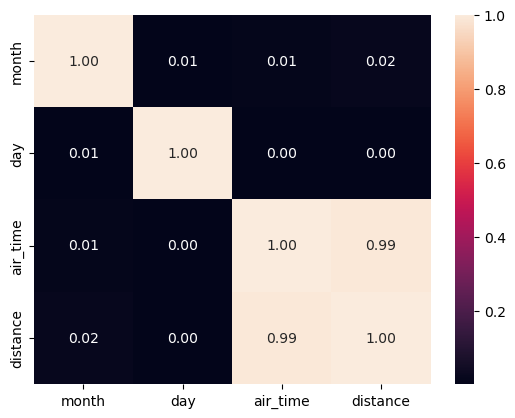

In [42]:
sns.heatmap(data=df_2_num.select_dtypes(exclude='object').corr(),
            annot=True,
            fmt='.2f')

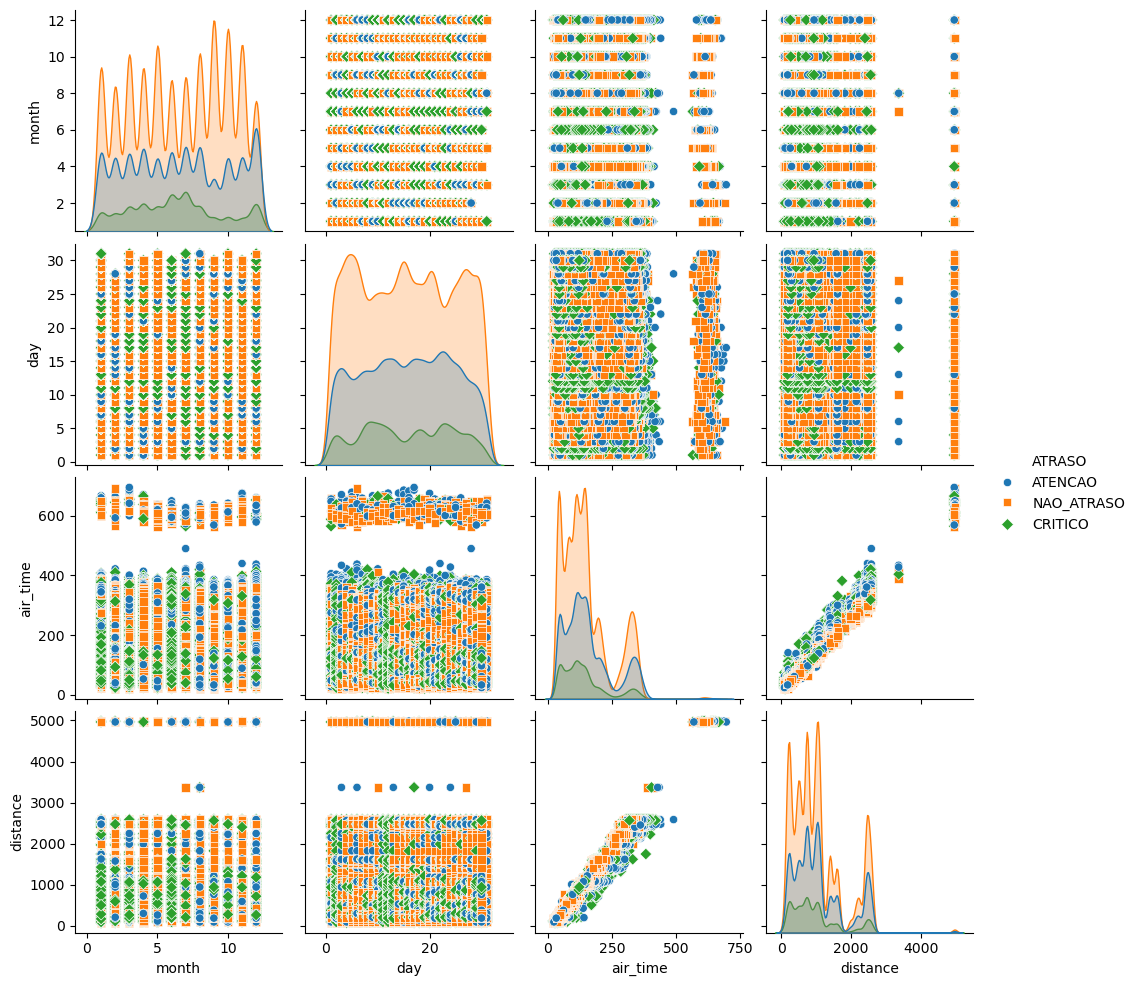

In [43]:
sns.pairplot(data=df_2_num,
             hue='ATRASO',
             markers=["o", "s", "D"]);

Obviamente, quanto mais distância percorrida, mais tempo o mesmo fica no ar.\
Podemos observar também que as proporções dos atrasos se mantêm iguais na maioria das variáveis.\
Ao observar o dia, vamos analisar com mais detalhes

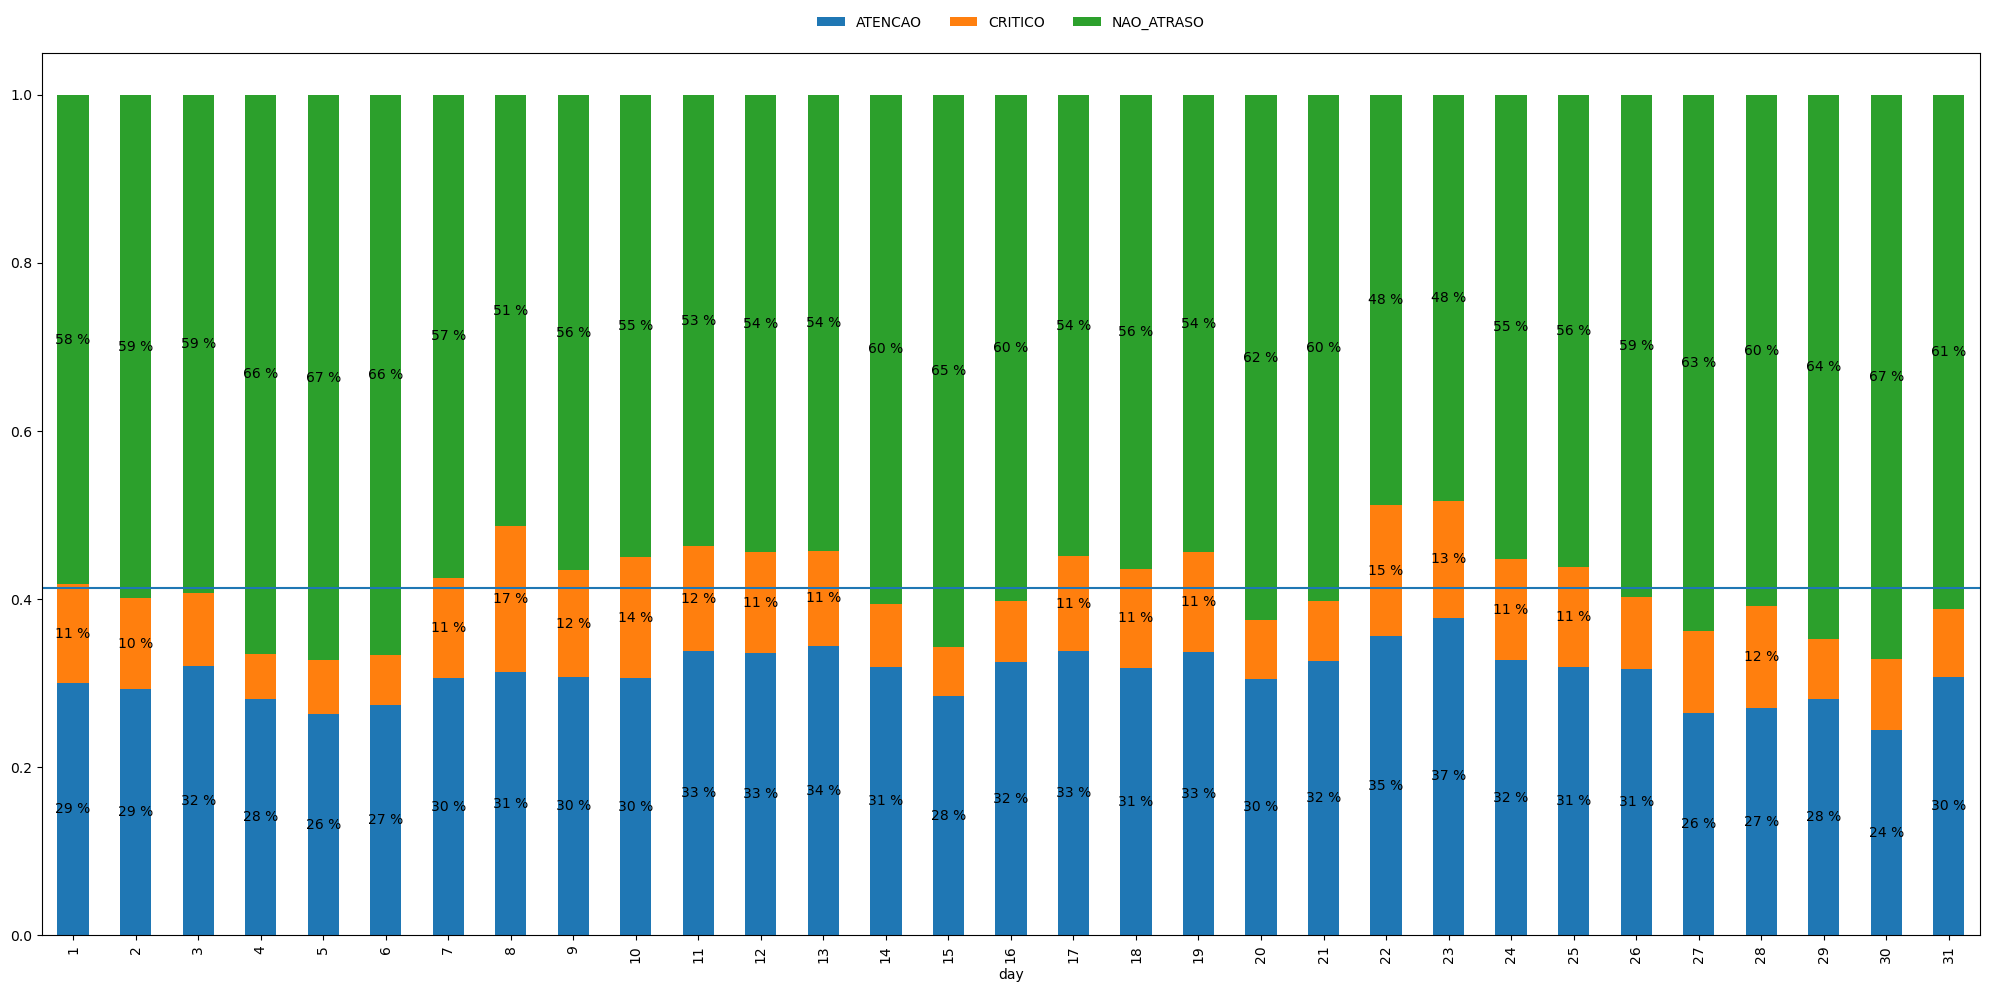

In [44]:
df_dia_pec = df_2_num.groupby('day')['ATRASO'].value_counts(normalize=True).unstack('ATRASO')
df_dia_pec.plot.bar(stacked=True,figsize=(20,10))
plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
for ix, row in df_dia_pec.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            plt.text(
                ix,
                cumulative + element / 2,
                f"{int(element * 100)} %",
                va="center",
                ha="center",
            )
        cumulative += element
plt.axhline(0.4126)
plt.tight_layout()
plt.show()

Podemos observar que existe um tipo de sazonalidade desse atraso entre os dias 

O comportamento geral é de: 
- Primeira e última semana do mês --> Temos um cenário favorável
- Dias 22 e 23 são os piores dias

Vamos observar se esse padrão é observado em todos os meses

In [45]:
base_mes_dia = df_2_num.groupby(['month','day']).ATRASO.value_counts(normalize=True).unstack('ATRASO')

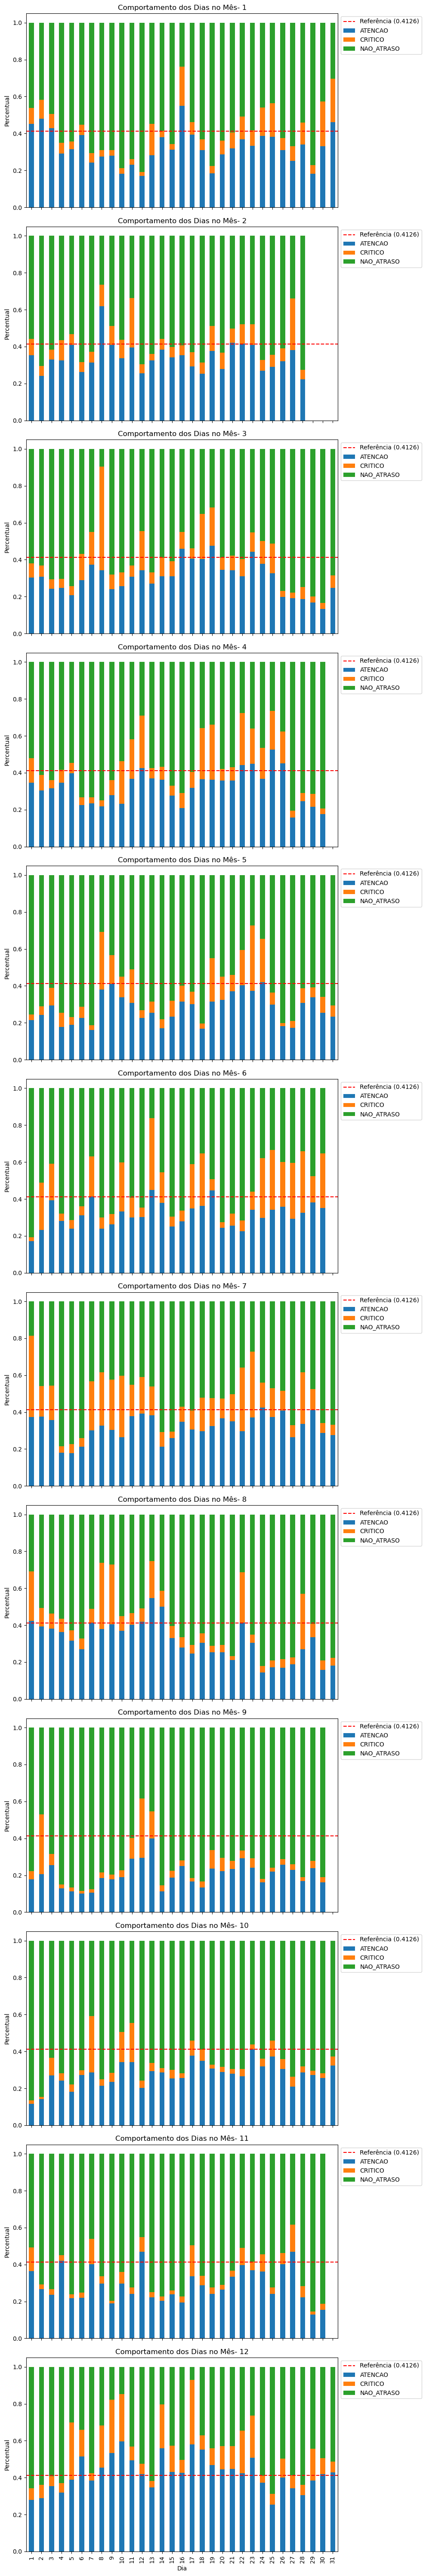

In [46]:
meses = base_mes_dia.index.get_level_values('month').unique()

# Criar uma figura e eixos para os gráficos
fig, axs = plt.subplots(nrows=len(meses), ncols=1, figsize=(10, len(meses) * 5), sharex=True)

if len(meses) == 1:
    axs = [axs]  # Garantir que axs seja uma lista se houver apenas um gráfico

# Plotar um gráfico para cada mês
for i, mes in enumerate(meses):
    dados_mes = base_mes_dia.loc[mes]
    dados_mes.plot(kind='bar', stacked=True, ax=axs[i], title=f'Comportamento dos Dias no Mês- {mes}')
    axs[i].set_xlabel('Dia')
    axs[i].set_ylabel('Percentual')
    axs[i].axhline(y=0.4126, color='red', linestyle='--', label=f'Referência ({0.4126})')
    axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Ajustar o layout
plt.tight_layout()
plt.show()

Levando em conta a classificação que fizemos dos meses de Férias, Baixa temporada e Padrão, podemos ter a seguinte conclusão:
- Meses de Férias: O período critico é de ultima semana de junho até dia 14 de agosto e o mês de dezembro como um todo
- Meses de Baixa temporada e Padrão: Meses 9, 10 e 11 performam muito bem independente do dia e o restante dos meses tem as variações observadas no geral

### Conclusões

- Podemos determinar:
1. Os dias mais críticos em relação ao atraso;
2. O período do ano em que temos maior incidência de voos atrasados;
3. As CIAS que contribuem para uma média maior de atraso;
4. A origem do voo não impacta em seu atraso

## 4. Variaveis Categóricas

### Tratamento Base

In [47]:
df_2.dtypes

year                     int64
month                    int64
day                      int64
dep_time               float64
dep_delay              float64
arr_time               float64
arr_delay              float64
carrier                 object
tailnum                 object
flight                  object
origin                  object
dest                    object
air_time               float64
distance                 int64
hour                   float64
minute                 float64
data            datetime64[ns]
atraso_total           float64
OUTLIER                 object
MES_FERIAS              object
ATRASO                  object
dtype: object

In [48]:
df_2_cat =  df_2.select_dtypes(include='object')

### Análise CIA aérea

Aqui iremos herdar a nossa análise prévia e criar os grupos de CIAs críticas e não críticas

In [49]:
df_2_cat.loc[df_2_cat.carrier.isin(['OO','F9','EV','YV','FL']),'GRUPO_CIA'] = 'CRITICO'
df_2_cat.loc[df_2_cat.carrier.isin(['AS','HA']),'GRUPO_CIA'] = 'OTIMO'
df_2_cat.loc[df_2_cat.GRUPO_CIA.isna(),'GRUPO_CIA'] = 'OUTROS'

In [63]:
df_2_cat.groupby('carrier').ATRASO.value_counts(normalize=True).unstack('ATRASO')

ATRASO,ATENCAO,CRITICO,NAO_ATRASO
carrier,,,
9E,0.265757,0.132763,0.601480
AA,0.256425,0.077503,0.666072
AS,0.210155,0.059238,0.730606
B6,0.331329,0.109734,0.558937
DL,0.277120,0.071530,0.651349
EV,0.314667,0.166001,0.519332
F9,0.462555,0.142438,0.395007
FL,0.452913,0.131024,0.416063
HA,0.225146,0.029240,0.745614


In [64]:
df_2_cat.groupby('GRUPO_CIA').ATRASO.value_counts(normalize=True).unstack('ATRASO')

ATRASO,ATENCAO,CRITICO,NAO_ATRASO
GRUPO_CIA,,,
CRITICO,0.324162,0.163747,0.512091
OTIMO,0.215033,0.049477,0.735490
OUTROS,0.307186,0.090527,0.602287


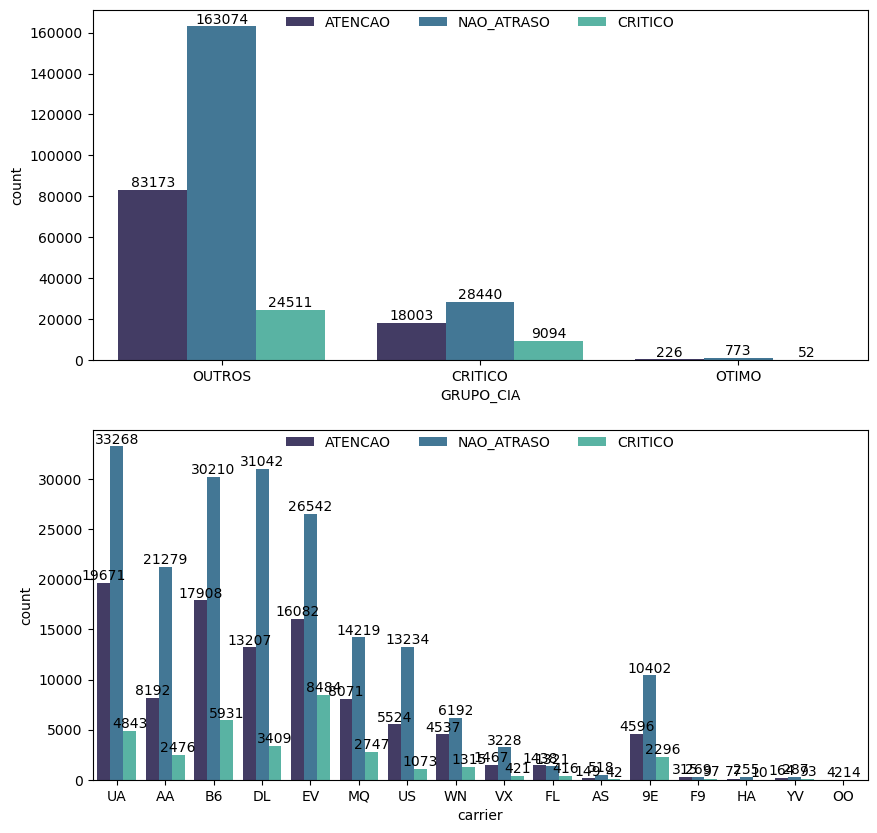

In [68]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
sns.countplot(data=df_2_cat,
              x='GRUPO_CIA',
              hue='ATRASO',
              ax=ax[0],
              palette='mako')
for bar in ax[0].containers:
    ax[0].bar_label(bar, fmt='%.0f', label_type='edge')
ax[0].legend(
    # bbox_to_anchor=(1, 1),
    loc="upper center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
sns.countplot(data=df_2_cat,
              x='carrier',
              hue='ATRASO',
              ax=ax[1],
              palette='mako')
for bar in ax[1].containers:
    ax[1].bar_label(bar, fmt='%.0f', label_type='edge')
ax[1].legend(
    # bbox_to_anchor=(0, 1.5),
    loc="upper center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)

Sendo assim, vamos analisar melhor gráficamente esses números

In [81]:
graf_1 = df_2_cat.groupby('carrier').ATRASO.value_counts(normalize=True).unstack('ATRASO')*100

In [82]:
graf_2 = df_2_cat.groupby('GRUPO_CIA').ATRASO.value_counts(normalize=True).unstack('ATRASO')*100

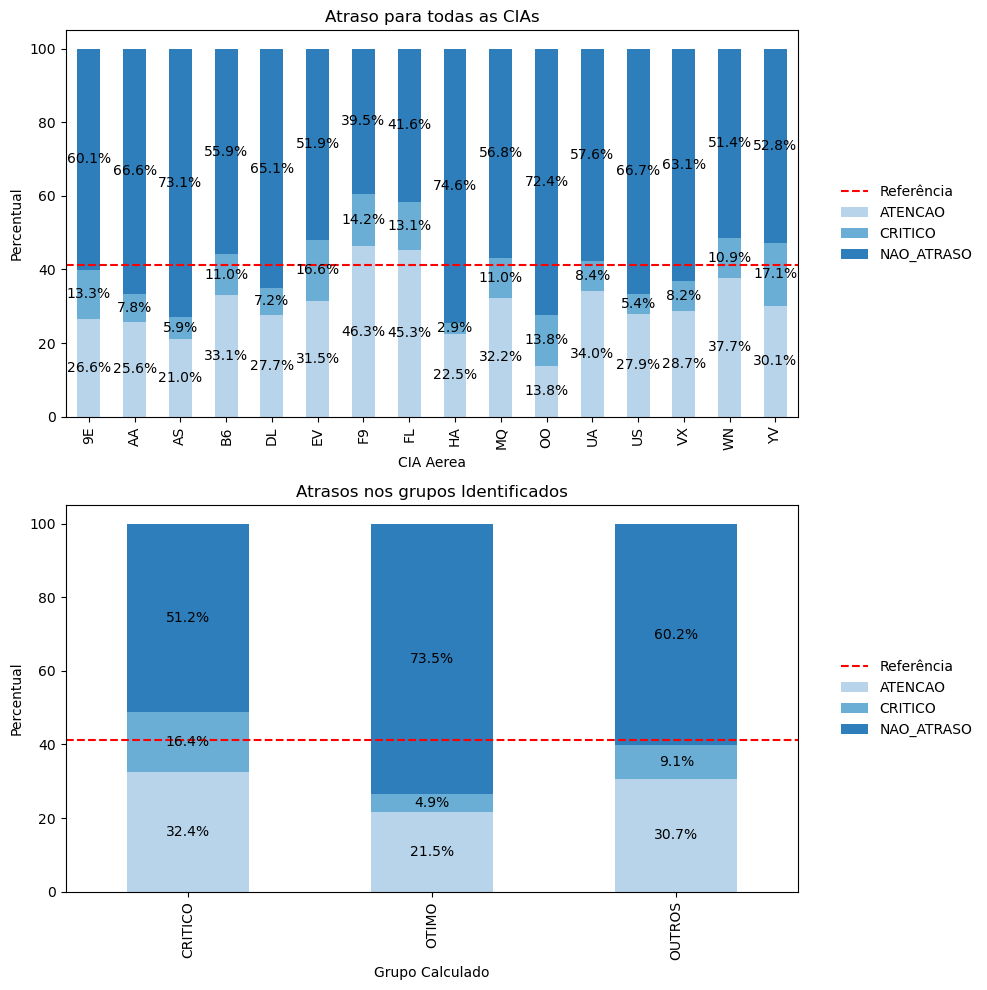

In [107]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
colors_1 = plt.cm.Blues(np.linspace(0.3, 0.7, len(graf_1.columns)))
colors_2 = plt.cm.Blues(np.linspace(0.3, 0.7, len(graf_2.columns)))
graf_1.plot(kind='bar',stacked=True,ax=ax[0],color = colors_1)
for bar in ax[0].containers:
    ax[0].bar_label(bar, fmt='%.1f%%', label_type='center')
ax[0].axhline(y=41.26, color='red', linestyle='--', label=f'Referência')
ax[0].legend(
    bbox_to_anchor = (1.05,0.5),
    loc='center left',
    borderaxespad=0,
    frameon=False,
    ncol=1,
)
ax[0].set_title('Atraso para todas as CIAs')
ax[0].set_xlabel('CIA Aerea')
ax[0].set_ylabel('Percentual')


graf_2.plot(kind='bar',stacked=True,ax=ax[1],color=colors_2)
for bar in ax[1].containers:
    ax[1].bar_label(bar, fmt='%.1f%%', label_type='center')
ax[1].axhline(y=41.26, color='red', linestyle='--', label=f'Referência')
ax[1].legend(
    bbox_to_anchor = (1.05,.5),
    loc='center left',
    borderaxespad=0,
    frameon=False,
    ncol=1,
)
ax[1].set_title('Atrasos nos grupos Identificados')
ax[1].set_xlabel('Grupo Calculado')
ax[1].set_ylabel('Percentual')


plt.tight_layout()
plt.show()


Sendo assim, pela análise qualitativa, podemos afirmar:

- F9, FL, EV e YV &rarr; São realmente as CIAs mais críticas.
- OO &rarr; Tem bons resultados em termos de voos, ou seja, quando a mesma atrasa, seu atraso é muito elevado;
- WN &rarr; Mesmo tendo resultados gerais favoráveis (abaixo da média), em representatividade, a mesma acaba por apresentar voos com atrasos críticos e em atenção acima do esperado

### Por voo (aeronave)

Para o 'tailnum' temos 4.037 valores (aeronaves) distintas, sendo assim, analisar uma a uma não seria viável\
Sendo assim, para analisar se a aeronave tem influencia sobre o voo, vamos analisar quantas aeronaves diferentes podemos encontrar ao realizar a análise de atraso

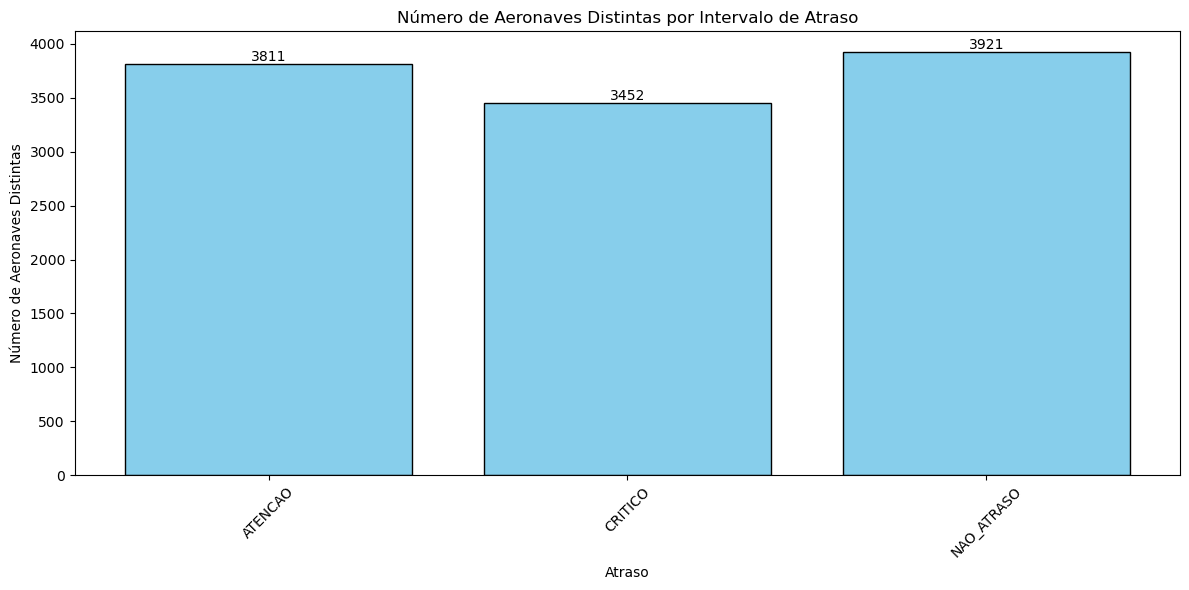

In [118]:
base_apoio_aeronave = df_2_cat.groupby('ATRASO').tailnum.nunique() 
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(base_apoio_aeronave.index, base_apoio_aeronave.values, color='skyblue', edgecolor='black')
ax.set_title('Número de Aeronaves Distintas por Intervalo de Atraso')
ax.set_xlabel('Atraso')
ax.set_ylabel('Número de Aeronaves Distintas')
for bar in ax.containers:
    ax.bar_label(bar, fmt='%.0f', label_type='edge')
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X se necessário
plt.grid(False)
plt.tight_layout()
plt.show()

Vamos Detalhar um pouco melhor esta análise

In [119]:
df_2_cat = pd.concat([df_2_cat,df_2.atraso_total],
                     axis='columns')

In [121]:
df_2_cat.atraso_total.describe(percentiles=[0.25,.5,.75,.9,.99])

count    327346.000000
mean         19.450532
std          82.880678
min        -100.000000
25%         -21.000000
50%          -6.000000
75%          22.000000
90%          97.000000
99%         378.000000
max        2573.000000
Name: atraso_total, dtype: float64

In [147]:
nomes_labels = ['-100 a -10','-10 a 0','0 a 10','10 a 100','100 a 300','acima de 300']
df_2_cat['Bins_atraso'] = pd.cut(df_2_cat.atraso_total,
                                 bins=[-101,-10,0,10,100,300,2573],
                                 labels=nomes_labels)

C:\Users\engca\AppData\Local\Temp\ipykernel_15380\2798382406.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_apoio_aeronave_2 = df_2_cat.groupby('Bins_atraso').tailnum.nunique()


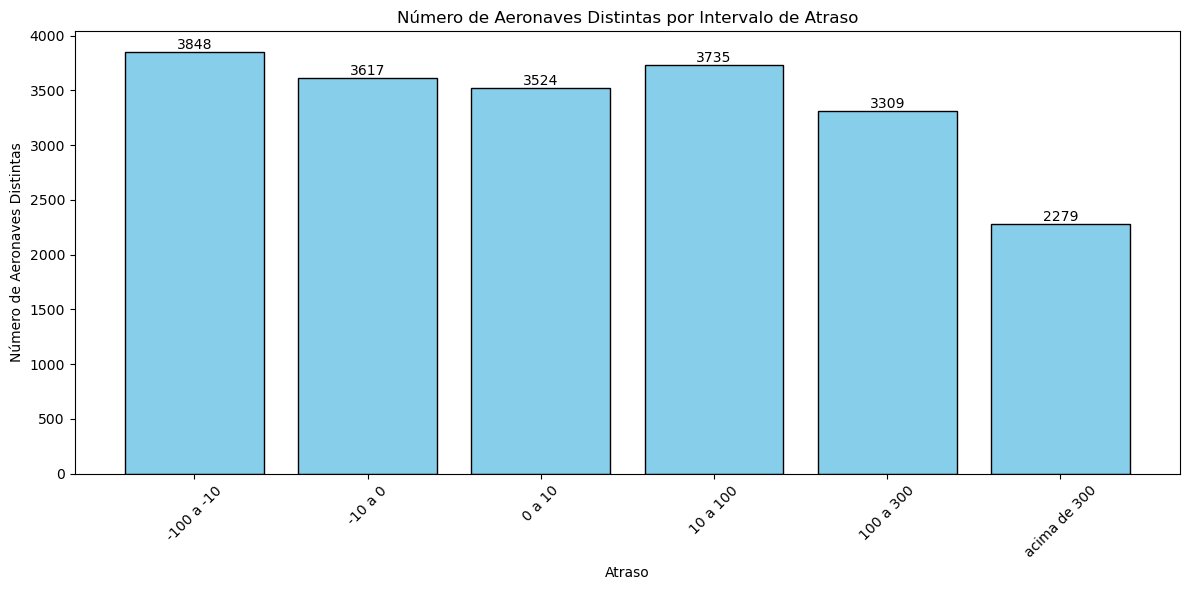

In [148]:
base_apoio_aeronave_2 = df_2_cat.groupby('Bins_atraso').tailnum.nunique() 
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(base_apoio_aeronave_2.index, base_apoio_aeronave_2.values, color='skyblue', edgecolor='black')
ax.set_title('Número de Aeronaves Distintas por Intervalo de Atraso')
ax.set_xlabel('Atraso')
ax.set_ylabel('Número de Aeronaves Distintas')
for bar in ax.containers:
    ax.bar_label(bar, fmt='%.0f', label_type='edge')
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X se necessário
plt.grid(False)
plt.tight_layout()
plt.show()

Será que existe uma aeronave que infulencia no resultado do "acima de 300" ?\
Vou testar se a aeronave mais frequente do 'bin' acima de 300 está presente nos demais

In [149]:
hipotese =  df_2_cat[df_2_cat.Bins_atraso == 'acima de 300'].tailnum.value_counts().index[0]

In [151]:
for i in df_2_cat.Bins_atraso.unique():
    if df_2_cat[(df_2_cat.tailnum == hipotese)&(df_2_cat.Bins_atraso == i)].shape[0] > 0:
        print(f'{hipotese} está presente na categoria {i}')
        print('-------------------------------')
    else: 
        print(f'{hipotese} não está presente na categoria {i}')
        print('-------------------------------')


N914XJ está presente na categoria 10 a 100
-------------------------------
N914XJ está presente na categoria -100 a -10
-------------------------------
N914XJ está presente na categoria 0 a 10
-------------------------------
N914XJ está presente na categoria -10 a 0
-------------------------------
N914XJ está presente na categoria 100 a 300
-------------------------------
N914XJ está presente na categoria acima de 300
-------------------------------


Sendo assim, podemos afirmar que, uma vez que a quantidade de aeronaves diferentes por atraso se mantém uniformemente distribuída, próxima do valor máximo em todos os intervalos de atraso e a aeronave mais frequente nos atrasos mais críticos também se faz presente nas outras categorias, não existe influencia da aeronave no resultado